### Machine Learning (C24), Spring 2024, Project Group F
-----
# Exploratory Data Analysis (EDA)
In this notebook, we explore the output from [02_data_outliers.ipynb](./02_data_outliers.ipynb) by looking at the most relevant **distributions** of variables and **relationships** between variable to inform our modeling approaches and choices. The followed EDA is conducted:
- Target variable(s) distributions (y-num)
- Feature variables distributions (X-num)
- Target variable correlations (y vs. X-num, X-cat)
- Feature variables correlations (Xi vs. Xj)

Insights gained for modeling:
1. Choose `'price actual'` for y target variable
2. No y vs. single-X (weather) linear correlations found so linear regression unlikely to be best model family (still try!)
3. Feature extraction to consider: weighted averages (across five cities) of weather variables
4. Dimensionality reduction to consider: `'generation*fossil*'`, `'temp*'` and `'humidity*'`

In [1]:
# Import libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# Import project custom functions
from functions import hist_text, box_text

In [2]:
# Output options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Read the joined energy + weather dataset
df = pd.read_csv('./Data/df_clean.csv', index_col='time', parse_dates=['time'])
df.shape #(35061, 91)

(35061, 91)

## Target variable(s) distributions
Basic univariates stats and visualization for target variable(s):
- **Previously:** solar and wind power generation (MW)
- **Currently:** electricity price (EUR/MWh)

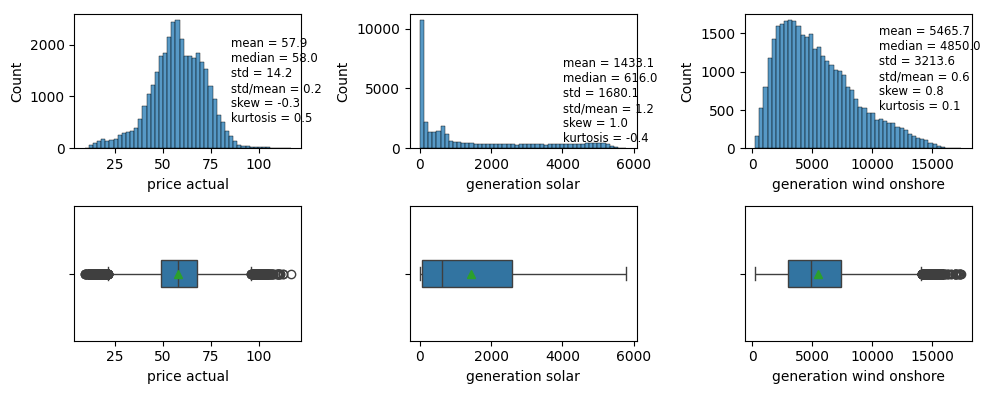

In [4]:
# Setup
y_cols = ['price actual', 'generation solar', 'generation wind onshore']
fig, axes = plt.subplots(2, 3, figsize=(10, 4))

# Plots and annotate text
for i, y_col in enumerate(y_cols):
    sns.histplot(data=df, x=y_col, bins=50, ax=axes[0][i])
    hist_text(axes[0][i], np.percentile(df[y_col], 80), 500, df[y_col], 1, 'small')
    sns.boxplot(data=df, x=y_col, width=0.2, showmeans=True, ax=axes[1][i])
    #box_text(axes[1][i], np.percentile(df[y_col], 75), 0.6, df[y_col], 1, 'small')
    
plt.tight_layout()
plt.show()

**Observations:** 
- `'price actual'` is the most "normal looking" distribution with the lowest absolute skew and lowest "coefficient of variation" (std divided by mean)
- `'generation wind onshore'` is a substantially skewed normal curve towards lower values, with high outliers
- `'generation solar'` looks like an expotential distribution with many values near zero

**Analysis:**
- The normality distribution of `'price actual'` may help performance of "some" machine learning algorithms
- It intuitively seems easier to predict although there are still many other factors

## Feature variables distributions
The [Kaggle](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather) source of this dataset provides histogram or value_counts distributions right on their **Data Card** tab. Interesting weather features to take a closer look at:
- temperature, pressure, humidity variations across five cities
- weather category value counts across five cities

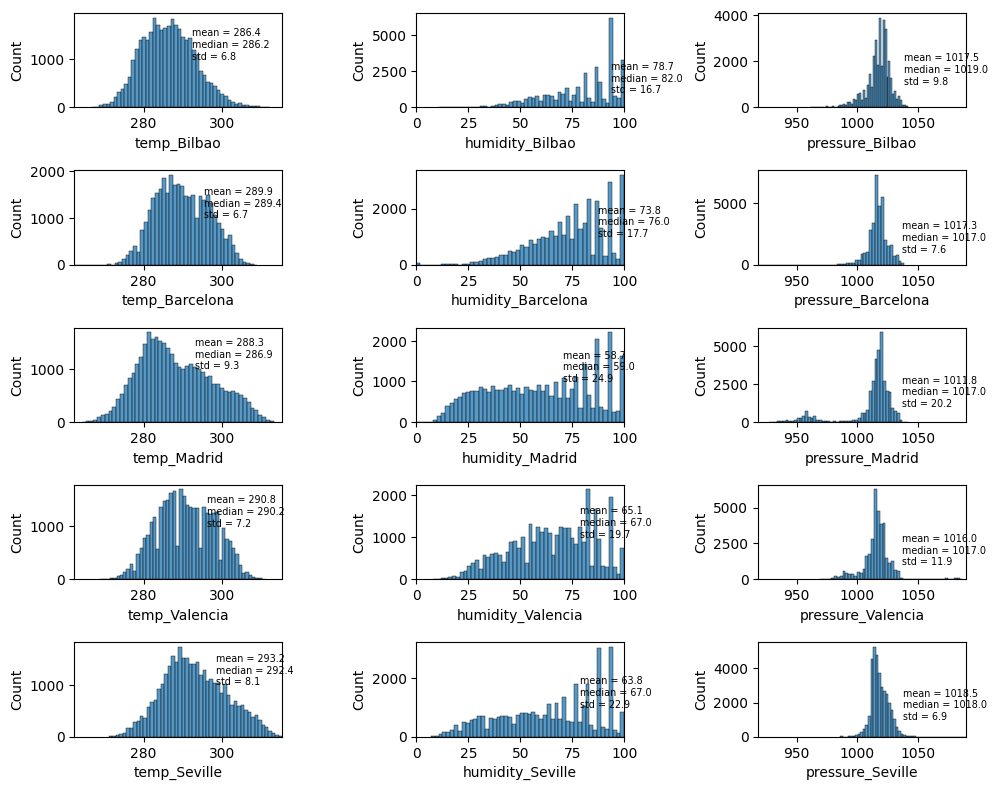

In [5]:
# Setup
weather_cols = [[col for col in df.columns if 'temp' in col],
                [col for col in df.columns if 'humidity' in col],
                [col for col in df.columns if 'pressure' in col]]
# Order by North to South of Spain
for i, _ in enumerate(weather_cols):
    weather_cols[i][0], weather_cols[i][1], weather_cols[i][2], weather_cols[i][3], weather_cols[i][4] = weather_cols[i][1], weather_cols[i][0], weather_cols[i][2], weather_cols[i][4], weather_cols[i][3]

# Get limits for consistent axes
col_mins = [min([min(df[col]) for col in weather_cols[0]]),
            min([min(df[col]) for col in weather_cols[1]]),
            min([min(df[col]) for col in weather_cols[2]])]
col_maxs = [max([max(df[col]) for col in weather_cols[0]]),
            max([max(df[col]) for col in weather_cols[1]]),
            max([max(df[col]) for col in weather_cols[2]])]
fig, axes = plt.subplots(5, 3, figsize=(10, 8))

# Plots and annotate text
for i, x_var in enumerate(weather_cols):
    for j, city in enumerate(x_var):
        sns.histplot(data=df, x=city, bins=50, ax=axes[j][i])
        axes[j][i].set_xlim(left=col_mins[i], right=col_maxs[i])
        hist_text(axes[j][i], np.percentile(df[city], 50), 1000, df[city], 1, 'x-small', False)  
    
plt.tight_layout()
plt.show()

**Observations:** 
- temperature curves do move to the right as we go south, Valencia exhibits some strange dips in the histogram
- humidity curve shapes vary more but it roughly varies inversely to temperature by city (e.g., low temp, high humidity)
- pressure varies little and seems similar in each city

## Target variable correlations
- Look at y vs. X numerical
- Look at y vs. X categorical

In [6]:
y_col = 'price actual'
s_y_corr = df.corr(method='pearson')[y_col].sort_values(ascending=False)
s_y_corr[abs(s_y_corr) >= 0.3]

price actual                                   1.000000
price_prev_1                                   0.966790
price_prev_2                                   0.900490
price_prev_3                                   0.821566
price day ahead                                0.732167
generation fossil hard coal                    0.465953
generation fossil gas                          0.461567
total load forecast                            0.435918
total load actual                              0.435638
generation fossil brown coal/lignite           0.364006
generation hydro pumped storage consumption   -0.426251
Name: price actual, dtype: float64

**Observations:**
- There are no moderate or strong correlations with any of the weather variables!
- High correlations relate to previous or "day ahead" prices
- Moderate correlations relate to fossil generation (more expensive?) and total loads (market)

**Analysis**
- The metric here is Pearson "linear" correlation which may foreshadow poor predictabiltiy using linear regression models

In [7]:
# Loop to recreate categorical column per city
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']
df2 = df.copy()
for city in cities:
    weather_cols = [col for col in df2.columns if ('weather' in col and city in col)]
    df2[f'weather_cat_{city}'] = df2[weather_cols].idxmax(axis=1).str.lstrip('weather_').str.rstrip(city)

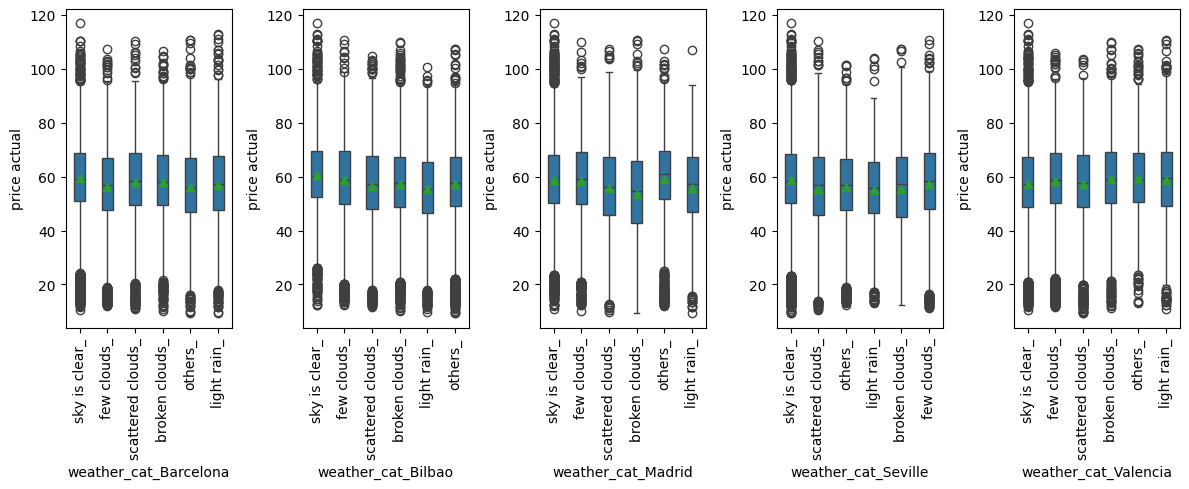

In [8]:
# Loop to plot original categorical variables in boxplots per city
weather_cats = [col for col in df2.columns if 'weather_cat' in col]
fig, axes = plt.subplots(1, 5, figsize=(12, 5))

for i, weather_cat in enumerate(weather_cats):
    sns.boxplot(data=df2, y='price actual', x=weather_cat, width=0.4, showmeans=True, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=90)
    
plt.tight_layout()
plt.show()

**Observations:**
- There is some noticable variation in some cities (e.g. lower price distribution with `'broken_clouds'` in Madrid) but very slight

**Analysis**
- These individual weather categories may be difficult to be identifiable as predictors since we have trying to see if **five cities'** weather patterns can predict ONE national price ➡️ consider weighted averages of numerical weather features

## Feature variables correlations
- Look at generation* variables together
- Look at per-city weather variables together

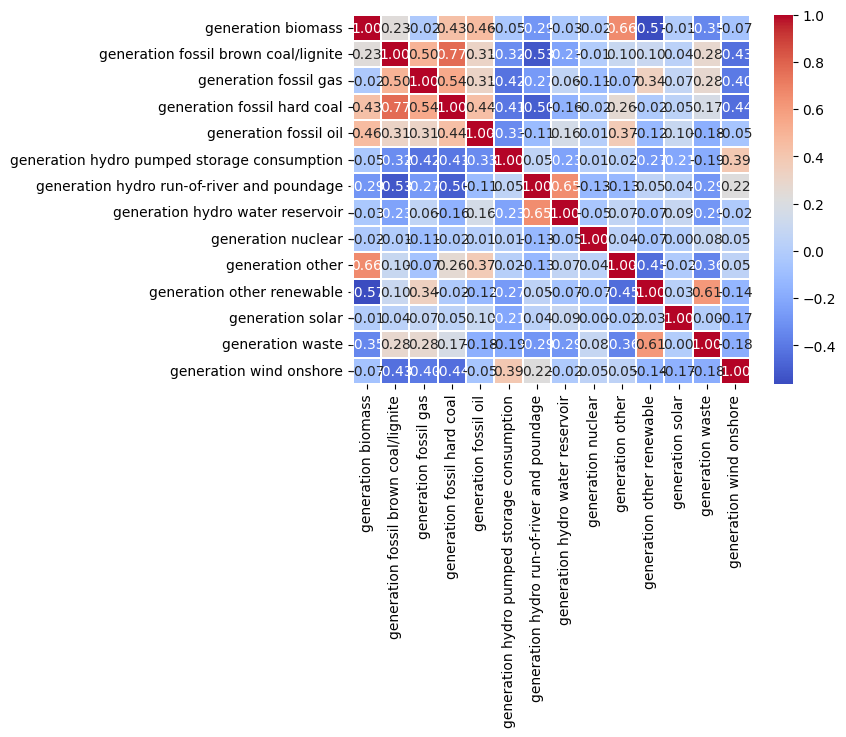

In [9]:
# Calculate correlations
generation_cols = [col for col in df2.columns if 'generation' in col]
df2_generation_corr = df2[generation_cols].corr(method='pearson')

# Plot heatmap
sns.heatmap(df2_generation_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.3)
plt.rcParams['font.size'] = 6

**Observations:**
- Strong correlations do exist between "fossil coal" generations (+0.77), and moderate correlations between other "fossil" generations
- The initial "y" variable of `'generation solar'` has no even moderate correlations
- The initial "y" variable of `'generation wind onshore'` has moderate **negative** correlations with some "fossil" generations which may suggest a balancing relationship

**Analysis**
- IF `'generation*'` variables prove to be important predictors, we could consider **dimensionality reduction** techniques to simplify model fitting

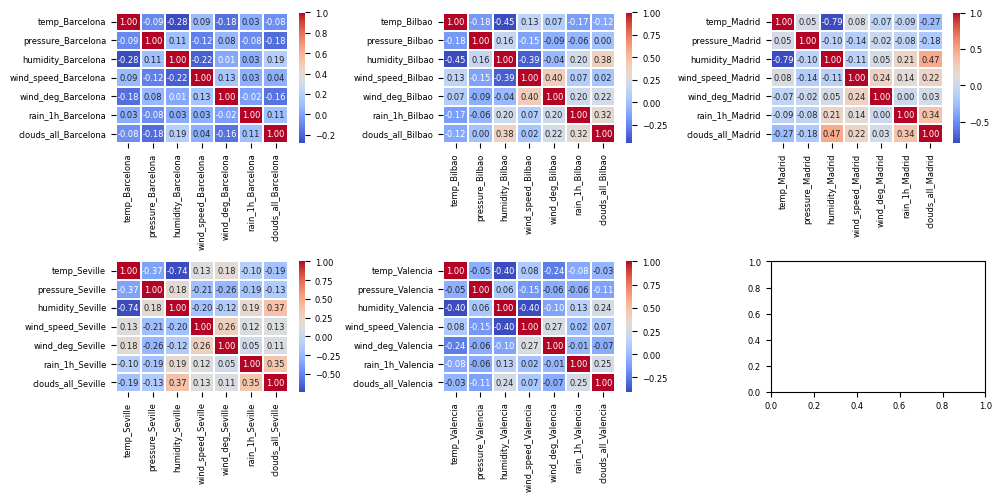

In [10]:
# Loop to recreate categorical column per city
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']
temp_vars = ['temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all']
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes = axes.flatten()

for i, city in enumerate(cities):
    city_weather_cols = [col for col in df2.columns if (city in col and col.replace(f'_{city}', '') in temp_vars)]
    df2_city_weather_corr = df2[city_weather_cols].corr(method='pearson')
    sns.heatmap(df2_city_weather_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.3, ax=axes[i])
  
plt.tight_layout()
plt.show()

**Observations:**
- As observed qualitatively above, temperature and humidity DO have an inverse correlation but that varies widely across cities:
    - **strong: Madrid (-0.79), Seville(-0.74)** ➡️ *they are both not on the coast!*
    - moderate: Bilbao, Valencia
    - weak: Barcelona

**Analysis**
- IF `'temp*'` and `'humidity'` variables prove to be important predictors, we could consider **dimensionality reduction** techniques to simplify model fitting